In [ ]:
!pip install torch torchvision matplotlib


  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (99 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21

In [1]:
!pip install kaggle -q
!cp kaggle.json ~/.kaggle/
!kaggle datasets download -d alxmamaev/flowers-recognition
!unzip -qq flowers-recognition.zip

cp: cannot stat 'kaggle.json': No such file or directory
Dataset URL: https://www.kaggle.com/datasets/alxmamaev/flowers-recognition
License(s): unknown
 96% 216M/225M [00:02<00:00, 89.3MB/s]
100% 225M/225M [00:03<00:00, 75.1MB/s]


In [2]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import numpy as np
import os
import random


In [3]:
data_dir = 'flowers'
categories = ['daisy', 'dandelion', 'rose', 'sunflower', 'tulip']

datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

train_generator = datagen.flow_from_directory(
    data_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical',
    subset='training'
)

validation_generator = datagen.flow_from_directory(
    data_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical',
    subset='validation'
)


Found 3457 images belonging to 5 classes.
Found 860 images belonging to 5 classes.


In [4]:
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(5, activation='softmax')
])

model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


In [9]:
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size,
    epochs=8  # increase this number for better accuracy
)


Epoch 1/8
108/108 [==============================] - 226s 2s/step - loss: 0.5356 - accuracy: 0.8061 - val_loss: 0.9530 - val_accuracy: 0.6671
Epoch 2/8
108/108 [==============================] - 236s 2s/step - loss: 0.3827 - accuracy: 0.8564 - val_loss: 1.1363 - val_accuracy: 0.6514
Epoch 3/8
108/108 [==============================] - 227s 2s/step - loss: 0.2687 - accuracy: 0.9051 - val_loss: 1.1825 - val_accuracy: 0.6587
Epoch 4/8
108/108 [==============================] - 222s 2s/step - loss: 0.1585 - accuracy: 0.9501 - val_loss: 1.2481 - val_accuracy: 0.6803
Epoch 5/8
108/108 [==============================] - 234s 2s/step - loss: 0.1390 - accuracy: 0.9542 - val_loss: 1.4884 - val_accuracy: 0.6370
Epoch 6/8
108/108 [==============================] - 227s 2s/step - loss: 0.1497 - accuracy: 0.9562 - val_loss: 1.4844 - val_accuracy: 0.6743
Epoch 7/8
108/108 [==============================] - 233s 2s/step - loss: 0.1121 - accuracy: 0.9658 - val_loss: 1.6045 - val_accuracy: 0.6683
Epoch 

Found 4317 images belonging to 5 classes.
134/134 [==============================] - 67s 499ms/step - loss: 0.3426 - accuracy: 0.9305
Test accuracy: 93.05%
134/134 [==============================] - 68s 510ms/step


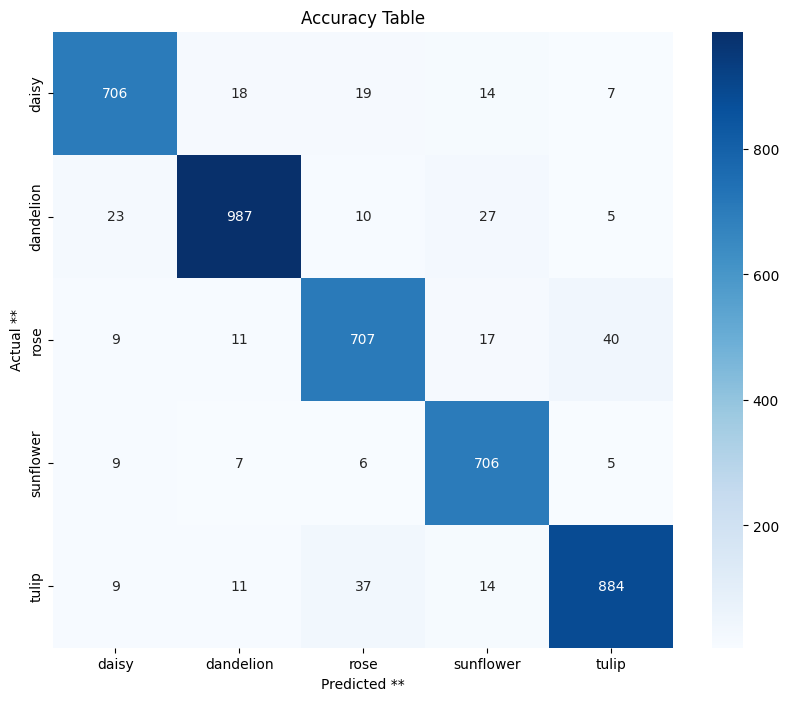

In [12]:
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    data_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

test_loss, test_acc = model.evaluate(test_generator, steps=test_generator.samples // test_generator.batch_size)
print(f'Test accuracy: {test_acc*100:.2f}%')

test_steps = test_generator.samples // test_generator.batch_size
test_generator.reset()
predictions = model.predict(test_generator, steps=test_steps, verbose=1)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = test_generator.classes[:len(predicted_classes)]
class_labels = list(test_generator.class_indices.keys())

from sklearn.metrics import confusion_matrix
import seaborn as sns

conf_matrix = confusion_matrix(true_classes, predicted_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.ylabel('Actual **')
plt.xlabel('Predicted **')
plt.title('Accuracy Table')
plt.show()
